# EOSC 573 - Final Project
### Analysis of Feb 19, 2021 CTD data

In [1]:
import scipy.io as spio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

import cartopy
import cartopy.crs as ccrs
from cartopy.feature import GSHHSFeature

import cmocean

In [2]:
def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    data = spio.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)

def _check_keys(dict):
    '''
    checks if entries in dictionary are mat-objects. If yes
    todict is called to change them to nested dictionaries
    '''
    for key in dict:
        if isinstance(dict[key], spio.matlab.mio5_params.mat_struct):
            dict[key] = _todict(dict[key])
    return dict        

def _todict(matobj):
    '''
    A recursive function which constructs from matobjects nested dictionaries
    '''
    dict = {}
    for strg in matobj._fieldnames:
        elem = matobj.__dict__[strg]
        if isinstance(elem, spio.matlab.mio5_params.mat_struct):
            dict[strg] = _todict(elem)
        else:
            dict[strg] = elem
    return dict

In [3]:
CTD = loadmat('RBRfeb192021.mat')['R1p3']['data'];

In [4]:
#column of values that each data type is in
temp = 1
press = 8
depth = 3
salinity = 4

In [5]:
#loop to remove rows with NaN
for i in range(len(CTD)):
    CTD[i].values = CTD[i].values[~np.isnan(CTD[i].values).any(axis=1)]

In [6]:
#remove all up-cast rows (preprocessing only done on down-cast for some reason)
r = [i for i in range(len(CTD)) if CTD[i].direction == 'down']
CTD=CTD[r]

(7.0, 8.5, 55.0, -3.0)

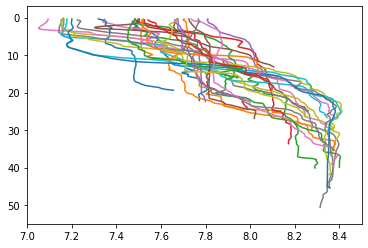

In [7]:
for i in range(len(CTD)):
    plt.plot(CTD[i].values[:,temp], CTD[i].values[:,press])
plt.axis([7,8.5,55,-3])

(25.0, 30.0, 55.0, -3.0)

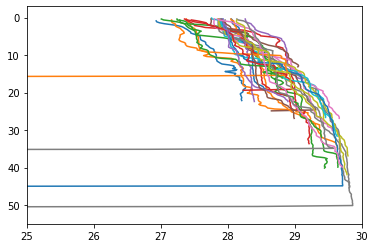

In [8]:
for i in range(len(CTD)):
    plt.plot(CTD[i].values[:,salinity], CTD[i].values[:,press])
plt.axis([25,30,55,-3])

cutting out the NaN was clraely not enough to get rid of the weird values here! try again

In [9]:
for i in range(len(CTD)):
    for j in range(len(CTD[i].values)-1):
        if CTD[i].values[j,salinity]-CTD[i].values[j+1,salinity] >0.5:
            print(i, end =",")

5,17,17,20,20,21,21,23,27,27,

In [10]:
#the amount that each of those needs to be trimmed by is equal to the amount of times they are repeated in that list

#make sure to only run this cell once! trimming the wonky values off the end
CTD[5].values = CTD[5].values[:-1,:]
CTD[17].values = CTD[17].values[:-2,:]
CTD[20].values = CTD[20].values[:-2,:]
CTD[21].values = CTD[21].values[:-2,:]
CTD[23].values = CTD[23].values[:-1,:]
CTD[27].values = CTD[27].values[:-2,:]

(25.0, 30.0, 55.0, -3.0)

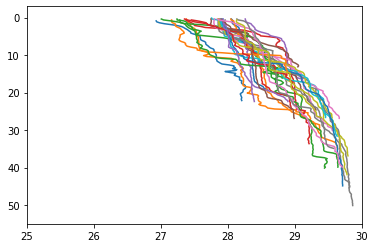

In [11]:
#plot salinity again to see if it looks ok
for i in range(len(CTD)):
    plt.plot(CTD[i].values[:,salinity], CTD[i].values[:,press])
plt.axis([25,30,55,-3])

### mapping

In [57]:
def make_map(projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(13, 13),
                           subplot_kw=dict(projection=projection))
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = gl.ylabels_right = False
    return fig, ax

In [58]:
central_lon, central_lat = -123.2, 49.3
extent = [-123.28, -123.13, 49.35, 49.25]

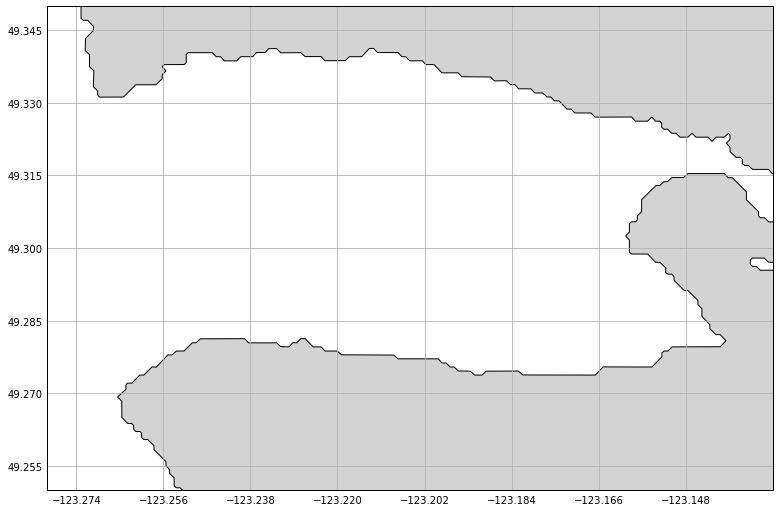

In [59]:
coast = GSHHSFeature(scale='full')

fig, ax = make_map(projection=ccrs.PlateCarree())
ax.set_extent(extent)
feature = ax.add_feature(coast, edgecolor='black', facecolor='lightgray')